# The MNIST database of handwritten digits in latent space 

## Model training

In [1]:
# data
import numpy as np 
import pandas as pd

#PCA
from sklearn.decomposition import PCA
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#TSNE
from sklearn.manifold import TSNE
#UMAP
import umap

# torch
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn

# visual
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
import plotly.express as px

# general
import copy
import time
import random
import os



In [2]:
# set seed
def set_seed() -> None:
    seed = 0
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


### Data

In [3]:
set_seed()
path_data = 'data'

# load the MNIST dataset from torchvision
train_dataset = torchvision.datasets.MNIST(path_data, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(path_data, train=False, download=True)

print('len train_dataset: ', len(train_dataset))
print('len test_dataset: ', len(test_dataset))
print(f'image size: {test_dataset[0][0].size} = {test_dataset[0][0].size[0]*test_dataset[0][0].size[1]}')



Random seed set as 0
len train_dataset:  60000
len test_dataset:  10000
image size: (28, 28) = 784


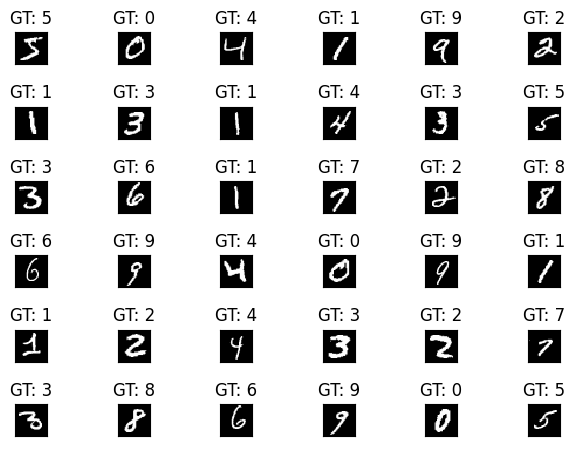

In [4]:
# inspect the data
fig = plt.figure()
for i in range(36):
  plt.subplot(6,6,i+1)
  plt.tight_layout()
  plt.imshow(train_dataset[i][0], cmap='gray', interpolation='none')

  plt.title(f"GT: {train_dataset[i][1]}")
  plt.xticks([])
  plt.yticks([])


In [5]:
# transform to tensor
train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

i=len(train_dataset)

# split data
train_data, val_data = random_split(train_dataset, [int(i-i*0.2), int(i*0.2)])
batch_size = 512

# init loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

### Model

In [6]:
# init the model
class Encoder(nn.Module):

    def __init__(self, encoded_space_dim):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU()
        )

        ### Flatten data
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(288, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_space_dim)
        )
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 288), 
            nn.ReLU()
        )

        self.unflatten = nn.Unflatten(dim=1,unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3,
                               stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2,
                               padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

### Setup

In [7]:
# training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader
    for image_batch, _ in dataloader:
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)



### testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [8]:
dims = [2,4,8,16,32,64,128]
encoders = []
test_loss_res=[]
for d in dims:
    # set seed
    set_seed()

    # learning setup
    loss_fn = torch.nn.MSELoss()
    lr = 0.001

    # select GPU ... if accessible
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print(f'Selected device: {device}')

    encoder = Encoder(encoded_space_dim=d)
    decoder = Decoder(encoded_space_dim=d)
    encoder.to(device)
    decoder.to(device)

    # optimizer
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

    num_epochs = 20
    for epoch in range(num_epochs):
       train_loss = train_epoch(encoder,decoder,device,
       train_loader,loss_fn,optim)
       val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)
       print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))

    test_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
    test_loss = test_loss.cpu().numpy()
    print('Final test loss:', test_loss)

    encoders.append(copy.deepcopy(encoder))
    test_loss_res.append(test_loss)
    
    torch.save(encoder.state_dict(), 'models/encoder_'+str(d)+'.pt')

df = pd.DataFrame(data={'test_loss': test_loss_res, 'dimensions': dims})

Random seed set as 0
Selected device: cuda

 EPOCH 1/20 	 train loss 0.1298900693655014 	 val loss 0.08976574242115021

 EPOCH 2/20 	 train loss 0.07241076976060867 	 val loss 0.060408130288124084

 EPOCH 3/20 	 train loss 0.054600756615400314 	 val loss 0.050632670521736145

 EPOCH 4/20 	 train loss 0.04813282936811447 	 val loss 0.04637322202324867

 EPOCH 5/20 	 train loss 0.045157190412282944 	 val loss 0.04409974440932274

 EPOCH 6/20 	 train loss 0.04346778616309166 	 val loss 0.042812883853912354

 EPOCH 7/20 	 train loss 0.04241235554218292 	 val loss 0.04207753390073776

 EPOCH 8/20 	 train loss 0.041655283421278 	 val loss 0.04150001332163811

 EPOCH 9/20 	 train loss 0.04106437414884567 	 val loss 0.04100542888045311

 EPOCH 10/20 	 train loss 0.04062018543481827 	 val loss 0.04067697748541832

 EPOCH 11/20 	 train loss 0.040207792073488235 	 val loss 0.0403188019990921

 EPOCH 12/20 	 train loss 0.03987923637032509 	 val loss 0.0402093306183815

 EPOCH 13/20 	 train loss 0.


 EPOCH 1/20 	 train loss 0.15862125158309937 	 val loss 0.11813093721866608

 EPOCH 2/20 	 train loss 0.08929985016584396 	 val loss 0.06675083190202713

 EPOCH 3/20 	 train loss 0.056322935968637466 	 val loss 0.044012729078531265

 EPOCH 4/20 	 train loss 0.0353868268430233 	 val loss 0.028032777830958366

 EPOCH 5/20 	 train loss 0.023657560348510742 	 val loss 0.019827306270599365

 EPOCH 6/20 	 train loss 0.017899880185723305 	 val loss 0.01625004969537258

 EPOCH 7/20 	 train loss 0.014415382407605648 	 val loss 0.013234635815024376

 EPOCH 8/20 	 train loss 0.01223067007958889 	 val loss 0.011191233061254025

 EPOCH 9/20 	 train loss 0.010778682306408882 	 val loss 0.010819059796631336

 EPOCH 10/20 	 train loss 0.00964411348104477 	 val loss 0.009211997501552105

 EPOCH 11/20 	 train loss 0.008793789893388748 	 val loss 0.008468338288366795

 EPOCH 12/20 	 train loss 0.008259238675236702 	 val loss 0.007879016920924187

 EPOCH 13/20 	 train loss 0.007756507955491543 	 val loss

In [9]:
# plot the trained models
fig = px.line(df, x="dimensions", y="test_loss", title='Testdata: loss vs. latent dimensions')
fig.show()

## Visualization

In [10]:
# load the trained models
encoders = []
for d in dims:  
    encoder = Encoder(encoded_space_dim=d).to(device)
    encoder.load_state_dict(torch.load('models/encoder_'+str(d)+'.pt'))
    encoders.append(encoder)


In [11]:
# run model on test data => get latent space
def get_encoded_df(encoder):
    encoded_samples = []
    for sample in tqdm(test_dataset):
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        # Encode image
        encoder.eval()
        with torch.no_grad():
            encoded_img  = encoder(img)
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"dim {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = label
        encoded_samples.append(encoded_sample)
    encoded_samples = pd.DataFrame(encoded_samples)
    return encoded_samples

In [12]:
# plot the model of the 2 dimensional latent space
encoded_samples = get_encoded_df(encoders[0])

px.scatter(encoded_samples, x='dim 0', y='dim 1', labels={'dim 0': 'dim 1', 'dim 1': 'dim 2'},
           color=encoded_samples.label.astype(str)) # opacity=0.7

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1850.26it/s]


## Comparison of different unsupervised learning algorithms for dimension reduction

In [13]:
# load encoder of 32 dim embedding
encoded_samples = get_encoded_df(encoders[4])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1830.65it/s]


In [14]:
x = encoded_samples.iloc[:,:-1]
y = encoded_samples.iloc[:,-1]

### pca

In [15]:
start = time.time()
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
print(f'Duration: {time.time() - start} seconds')
pca_df = pd.DataFrame(data = principalComponents
             , columns = ['pc_1', 'pc_2'])

fig = px.scatter(pca_df, x='pc_1', y='pc_2',
                 color=encoded_samples.label.astype(str))
fig.show()

Duration: 0.06872749328613281 seconds


### lda

In [16]:
start = time.time()
lda = LDA(n_components=2).fit_transform(x,y)
print(f'Duration: {time.time() - start} seconds')

pca_df = pd.DataFrame(data = lda
             , columns = ['lda_1', 'lda_2'])

fig = px.scatter(pca_df, x='lda_1', y='lda_2',
                 color=encoded_samples.label.astype(str))
fig.show()



Duration: 0.056876420974731445 seconds


### t-sne

In [17]:
start = time.time()
tsne = TSNE(random_state = 0, n_components=2, verbose=0, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(x)
print(f'Duration: {time.time() - start} seconds')

fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne 1', '1': 'tsne 2'})
fig.show()

Duration: 14.396714210510254 seconds


### umap

In [18]:
start = time.time()
reducer = umap.UMAP(random_state=42,n_components=2)
embedding = reducer.fit_transform(x)
print('Duration: {} seconds'.format(time.time() - start))

umap_df = pd.DataFrame(data = embedding
             , columns = ['umap_1', 'umap_2'])

fig = px.scatter(umap_df, x='umap_1', y='umap_2',
                 color=encoded_samples.label.astype(str))
fig.show()


Duration: 18.98189115524292 seconds
